**Ethan Seal and Cole Turner**

Fall 2019

CS343: Neural Networks

Project 5: Word embeddings and SOMs

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 3) Implement a Self-Organizing Map (SOM) neural network

You will implement a SOM to visualize the word embeddings in 2D.

Implement the method stubs in `som.py`. I suggest working in the following order:
- constructor
- `compute_decayed_param`. Equation is $$p(t) = p\times exp \left (-t / \left ( \frac{T}{2} \right ) \right ) $$ Above, $p$ is the parameter (e.g. learning rate), $t$ is the current training iteration, $T$ is the total number of training iterations.
- `gaussian`.  Equation is: $$g(r, c) = \alpha(t)\times exp \left (- \left (|| M_{x,y} - (c,r) || \right ) / \left ( 2 \sigma^2 \right ) \right ) $$Above, $\alpha(t)$ is the current (decayed) learning rate, $M_{x,y}$ is the BMU neighborhood grid of (x,y) ordered pairs of SOM unit indices/positions, $(c,r)$ is the center of the Gaussian (BMU column, row position), and $\sigma$ is the current (decayed) standard deviation, $||\cdot||$ is the $L^2$ norm (over x,y values).
- `fit`
- `get_bmu`
- `get_nearest_wts`
- `update_wts`. SOM update rule is $$\vec{w_{rc}}(t) = \vec{w_{rc}}(t-1) + g(r_{bmu}, c_{bmu})\left ( \vec{\text{input_i}} - \vec{w_{rc}}(t-1)\right )$$Above, $w_{rc}$ is the SOM weight vector belonging to the unit positioned at row $r$ and column $c$, $t$ is iteration number, $g(r_{bmu}, c_{bmu})$ is the Gaussian neighborhood matrix centered on the BMU evaluated at the SOM $(row, col) = (r, c)$, $\text{input_i}$ is the data vector. NOTE: This weight update occurs to ALL SOM unit rows and columns $(r, c)$ at time t (due to the Gaussian neighborhood function).
- `error`
- `u_matrix`

As you implement, use the below code to test your implementation. This starts with simple toy data, then on the Iris dataset.

### a. Test implementation

In [2]:
import som

#### Test constructor

In [3]:
som_sz = 3
n_features = 2
max_iter = 10

np.random.seed(0)

test_som = som.SOM(som_sz, n_features, max_iter)
print(f'Your SOM initial weights (shape: {test_som.get_wts().shape}) are\n{test_som.get_wts()}')

Your SOM initial weights (shape: (3, 3, 2)) are
[[[ 0.975  0.221]
  [ 0.4    0.916]
  [ 0.886 -0.464]]

 [[ 0.988 -0.157]
  [-0.244  0.97 ]
  [ 0.099  0.995]]

 [[ 0.987  0.158]
  [ 0.799  0.601]
  [ 0.991 -0.136]]]


You should see:

    Your SOM initial weights (shape: (3, 3, 2)) are
    [[[ 0.975  0.221]
      [ 0.4    0.916]
      [ 0.886 -0.464]]

     [[ 0.988 -0.157]
      [-0.244  0.97 ]
      [ 0.099  0.995]]

     [[ 0.987  0.158]
      [ 0.799  0.601]
      [ 0.991 -0.136]]]

In [4]:
print(f'Shapes of your BMU neighborhood x {test_som.bmu_neighborhood_x.shape} and y {test_som.bmu_neighborhood_y.shape}.')
print('They should be (3, 3), (3, 3), and (3, 3)')
min_x, max_x = test_som.bmu_neighborhood_x.min(), test_som.bmu_neighborhood_x.max()
min_y, max_y = test_som.bmu_neighborhood_y.min(), test_som.bmu_neighborhood_y.max()
print(f'min/max of your x, y neighborhood grids are {min_x}/{max_x}, {min_y}/{max_y}')
print('They should be 0/2, 0/2')

Shapes of your BMU neighborhood x (3, 3) and y (3, 3).
They should be (3, 3), (3, 3), and (3, 3)
min/max of your x, y neighborhood grids are 0/2, 0/2
They should be 0/2, 0/2


#### Test learning rate decay function

In [5]:
vec = np.arange(10)
print(test_som.compute_decayed_param(vec, 1))
print(test_som.compute_decayed_param(20, vec[::-1]))

[1.    0.819 0.67  0.549 0.449 0.368 0.301 0.247 0.202 0.165]
[0.165 0.147 0.128 0.11  0.092 0.073 0.055 0.037 0.018 0.   ]


You should see:

    [1.    0.819 0.67  0.549 0.449 0.368 0.301 0.247 0.202 0.165]
    [0.165 0.147 0.128 0.11  0.092 0.073 0.055 0.037 0.018 0.   ]

#### Test Gaussian neighborhood function

##### Test 1

In [6]:
cent_xy = (1, 1)
sigma = 1.0
lr = 1.0
print(test_som.gaussian(cent_xy, sigma, lr))

[[[0.368]
  [0.607]
  [0.368]]

 [[0.607]
  [1.   ]
  [0.607]]

 [[0.368]
  [0.607]
  [0.368]]]


The Test 1 Gaussian neighborhood should look like:

    [[0.368 0.607 0.368]
     [0.607 1.    0.607]
     [0.368 0.607 0.368]]

##### Test 2

In [7]:
cent_xy = (0, 1)
print(test_som.gaussian(cent_xy, sigma, lr))

[[[0.607]
  [1.   ]
  [0.607]]

 [[0.368]
  [0.607]
  [0.368]]

 [[0.082]
  [0.135]
  [0.082]]]


The Test 2 Gaussian neighborhood should look like:

    [[0.607 1.    0.607]
     [0.368 0.607 0.368]
     [0.082 0.135 0.082]]

##### Test 3

In [8]:
cent_xy = (0, 1)
sigma = 0.5
print(test_som.gaussian(cent_xy, sigma, lr))

[[[0.135]
  [1.   ]
  [0.135]]

 [[0.018]
  [0.135]
  [0.018]]

 [[0.   ]
  [0.   ]
  [0.   ]]]


The Test 3 Gaussian neighborhood should look like:

    [[0.135 1.    0.135]
     [0.018 0.135 0.018]
     [0.    0.    0.   ]]

##### Test 4

In [9]:
cent_xy = (0, 1)
sigma = 0.5
lr = 0.5
print(test_som.gaussian(cent_xy, sigma, lr))

[[[0.068]
  [0.5  ]
  [0.068]]

 [[0.009]
  [0.068]
  [0.009]]

 [[0.   ]
  [0.   ]
  [0.   ]]]


The Test 4 Gaussian neighborhood should look like:

    [[0.068 0.5   0.068]
     [0.009 0.068 0.009]
     [0.    0.    0.   ]]

#### Test `get_nearest_wts` and  `get_bmu`

In [10]:
test_vec1 = np.array([0.916, 0.4])
test_vec1 = test_vec1[np.newaxis, ...]
test_som.get_nearest_wts(test_vec1)
print(f'The nearest wt vector to [0.916, 0.4] is {test_som.get_nearest_wts(test_vec1)[0]} and should be [0.975 0.221]')
test_vec2 = np.array([-1, -1])
test_vec2 = test_vec2[np.newaxis, ...]
print(f'The nearest wt vector to [-1, -1] is {test_som.get_nearest_wts(test_vec2)[0]} and should be [ 0.886 -0.464]')

The nearest wt vector to [0.916, 0.4] is [0.975 0.221] and should be [0.975 0.221]
The nearest wt vector to [-1, -1] is [ 0.886 -0.464] and should be [ 0.886 -0.464]


#### Test `update_wts`

In [11]:
np.random.seed(0)
som_sz = 3 # 5, 5
n_features = 2
max_iter = 10
t = 1

test_som = som.SOM(som_sz, n_features, max_iter)

input_vector = np.array([1, 1])
bmu_xy = (1, 1)

test_som.update_wts(t, input_vector, bmu_xy)
print(f'Weights after update are:\n{test_som.get_wts()}')

Weights after update are:
[[[ 0.979  0.347]
  [ 0.498  0.93 ]
  [ 0.904 -0.228]]

 [[ 0.99   0.031]
  [-0.04   0.975]
  [ 0.245  0.996]]

 [[ 0.989  0.294]
  [ 0.832  0.666]
  [ 0.992  0.047]]]


    Weights after update are:
    [[[ 0.979  0.347]
      [ 0.498  0.93 ]
      [ 0.904 -0.228]]

     [[ 0.99   0.031]
      [-0.04   0.975]
      [ 0.245  0.996]]

     [[ 0.989  0.294]
      [ 0.832  0.666]
      [ 0.992  0.047]]]

#### Test U-matrix

In [12]:
np.random.seed(0)
som_sz = 3 # 3, 3
n_features = 2
max_iter = 10

test_som = som.SOM(som_sz, n_features, max_iter)

In [13]:
print(f'Your U-matrix is:\n{test_som.u_matrix()}')

Your U-matrix is:
[[0.267 0.448 0.487]
 [0.43  1.    0.449]
 [0.224 0.387 0.38 ]]


Your output should be:
    
    Your U-matrix is:
    [[0.267 0.448 0.487]
     [0.43  1.    0.449]
     [0.224 0.387 0.38 ]]

### b. Test `fit` with Iris dataset

You will use the Iris dataset to test your `fit` function. Your goal is to qualitatively (roughly) reproduce the example image on Wikipedia (below).

- Preprocess the data in the pandas Dataframe below to produce `iris_x` (training data) and `iris_y` (classes).
    - For the training data, pull out all columns except for "species", then normalize each row by its Euclidean distance so that each vector sums to 1. Convert it from Dataframe to ndarray.
    - For the classes, convert to "species" column to an int-code (e.g. values take on 0, 1, 2). Convert from Dataframe to ndarray. 

In [14]:
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [15]:
# make iris_x
iris_x = iris.copy()
iris_x = iris_x.drop(columns='species')
iris_x = iris_x.to_numpy()
for i in range(iris_x.shape[0]):
    iris_x[i] = iris_x[i] / np.linalg.norm(iris_x[i])

In [16]:
# make iris_y
iris_y = iris['species']
# print(iris_y)
int_coded = pd.factorize(iris_y)
# print(int_coded)
iris_y = int_coded[0]
print(iris_y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


#### Test Iris preprocessing

In [17]:
print(f'1st 4 rows of preprocessed iris:\n{iris_x[:4]}\n')
print(f'First 4 classes of iris:\n{iris_y[:4]}\n')
print(f'Last 4 classes of iris:\n{iris_y[-4:]}\n')

1st 4 rows of preprocessed iris:
[[0.804 0.552 0.221 0.032]
 [0.828 0.507 0.237 0.034]
 [0.805 0.548 0.223 0.034]
 [0.8   0.539 0.261 0.035]]

First 4 classes of iris:
[0 0 0 0]

Last 4 classes of iris:
[2 2 2 2]



Output should look like:

    1st 4 rows of preprocessed iris:
    [[0.804 0.552 0.221 0.032]
     [0.828 0.507 0.237 0.034]
     [0.805 0.548 0.223 0.034]
     [0.8   0.539 0.261 0.035]]

    First 4 classes of iris:
    [0 0 0 0]

    Last 4 classes of iris:
    [2 2 2 2]

##### Test `fit`, `u_matrix` after different number of training iterations

In [ ]:
som_sz = 7
n_features = 4
max_iter = 1

np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=0.2, init_sigma=10.0, verbose=False)
iris_u_map0 = iris_som.u_matrix()
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()
print(f'Quantization error after {max_iter} iterations: {iris_som.error(iris_x):.2f}')
print(f'Your initial u-matrix is (before any training):\n{iris_u_map0}')
print(f'Your u-matrix is (after 1 step):\n{iris_u_map}\n')

max_iter = 100
iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=0.2, init_sigma=10.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map2 = iris_som.u_matrix()
print(f'Quantization error after {max_iter} iterations: {iris_som.error(iris_x):.2f}')
print(f'Your u-matrix is (after 100 steps):\n{iris_u_map2}')

max_iter = 1000
iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=0.2, init_sigma=10.0, verbose=False)
iris_som.fit(iris_x.copy())
print(f'\nQuantization error after {max_iter} iterations: {iris_som.error(iris_x):.2f}')



You should see:

    Quantization error after 1 iterations: 0.14
    Your initial u-matrix is (before any training):
    [[0.268 0.495 0.516 0.496 0.635 0.582 0.39 ]
     [0.538 0.956 0.931 0.794 0.776 0.771 0.464]
     [0.506 0.911 0.831 0.988 1.    0.751 0.502]
     [0.524 0.771 0.748 0.85  0.879 0.886 0.618]
     [0.405 0.745 0.755 0.714 0.782 0.907 0.586]
     [0.586 0.798 0.733 0.761 0.801 0.959 0.494]
     [0.311 0.508 0.44  0.409 0.48  0.548 0.417]]
    Your u-matrix is (after 1 step):
    [[0.263 0.485 0.508 0.492 0.635 0.588 0.395]
     [0.528 0.937 0.917 0.787 0.776 0.778 0.472]
     [0.496 0.894 0.819 0.979 1.    0.757 0.51 ]
     [0.516 0.759 0.74  0.846 0.882 0.896 0.628]
     [0.402 0.739 0.752 0.715 0.79  0.923 0.6  ]
     [0.585 0.798 0.737 0.766 0.814 0.983 0.511]
     [0.312 0.511 0.445 0.415 0.491 0.565 0.433]]

    Quantization error after 100 iterations: 0.08
    Your u-matrix is (after 100 steps):
    [[0.049 0.21  0.419 0.606 0.648 0.583 0.298]
     [0.152 0.333 0.649 0.92  0.979 0.874 0.392]
     [0.215 0.488 0.71  0.96  1.    0.856 0.363]
     [0.435 0.719 0.9   0.98  0.966 0.798 0.38 ]
     [0.611 0.957 0.977 0.967 0.849 0.685 0.333]
     [0.668 0.999 0.957 0.853 0.722 0.552 0.241]
     [0.323 0.475 0.478 0.446 0.382 0.296 0.135]]

    Quantization error after 1000 iterations: 0.03

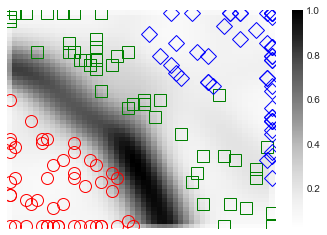

In [18]:
som_sz = 50
n_features = 4
max_iter = 1000

np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=3, init_sigma=51.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()

plt.pcolor(iris_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])

markers = ['o','s','D']
colors = ['r','g','b']

for i in range(len(iris_x)):
    bmu_pos = iris_som.get_bmu(iris_x[i])
    plt.plot(bmu_pos[0] + 0.5,
             bmu_pos[1] + 0.5,
             markers[iris_y[i]],
             markeredgecolor=colors[iris_y[i]],
             markersize=12,
             markerfacecolor='None')
plt.show()

- **Question 3**: What do the different shaped/colored plot markers represent in the visualization?
- **Answer 3**: They represent different classes that the data has been split into. There are three classes, represented by 0, 1, and 2. Each of those classes are different species. 

- **Question 4**: Explain what the above visualizaion is showing us. Why does the plot look different than Iris scatterplots like you're used to seeing? 
- **Answer 4**: The visualization is showing us the SOM-space representation of the Iris dataset. This means that its dimensionality has been reduced to 2, so it looks pretty different from the normal Iris scatterplots. 

- **Question 5**: How do we make use of the Iris classes (species) in the above visualization? Does training depend on them?
- **Answer 5**: We use the classes to do different colors and shapes in the above visualization. Training does not depend on the classes, as the map organizes itself based on the samples, and classes are predicted later.

- **Question 6**: Copy the plot with default hyperparameters into a separate cell (or save it in your project folder). Then play around with the hyperparameters. Report on what how each affects the map. Does it matter that the clusters may jump around? Explain why.

- **Question 7**: How stable are the hyperparameters in generating distinct clusters? Back up your observations with some numbers (i.e. parameter ranges ranges, things you experimented with).
- **Question 8**: See what happens when you shrink the map size. What's the consequence for classifying new data with the smaller map size?

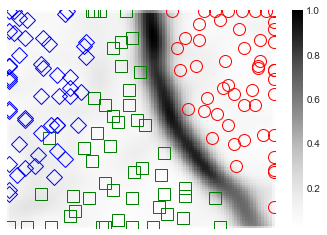

In [19]:
#Answer 6
som_sz = 100
n_features = 4
max_iter = 1000

np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=3, init_sigma=51.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()

plt.pcolor(iris_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])

markers = ['o','s','D']
colors = ['r','g','b']

for i in range(len(iris_x)):
    bmu_pos = iris_som.get_bmu(iris_x[i])
    plt.plot(bmu_pos[0] + 0.5,
             bmu_pos[1] + 0.5,
             markers[iris_y[i]],
             markeredgecolor=colors[iris_y[i]],
             markersize=12,
             markerfacecolor='None')
plt.show()

C:\Users\mynam\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\mynam\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:2513: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
C:\Users\mynam\onedrive\documents\classes\NeuralNetworks\project5\som.py:204: RuntimeWarning: overflow encountered in multiply
  self.wts[:, :] = self.wts[:, :] + gauss * (input_vector - self.wts[:, :])
C:\Users\mynam\onedrive\documents\classes\NeuralNetworks\project5\som.py:204: RuntimeWarning: invalid value encountered in add
  self.wts[:, :] = self.wts[:, :] + gauss * (input_vector - self.wts[:, :])


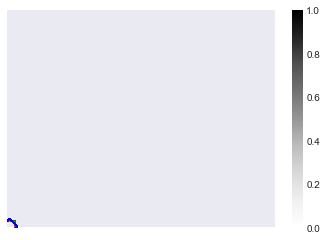

In [20]:
#Answer 6
som_sz = 70
n_features = 4
max_iter = 1000

np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=6, init_sigma=51.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()

plt.pcolor(iris_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])

markers = ['o','s','D']
colors = ['r','g','b']

for i in range(len(iris_x)):
    bmu_pos = iris_som.get_bmu(iris_x[i])
    plt.plot(bmu_pos[0] + 0.5,
             bmu_pos[1] + 0.5,
             markers[iris_y[i]],
             markeredgecolor=colors[iris_y[i]],
             markersize=12,
             markerfacecolor='None')
plt.show()

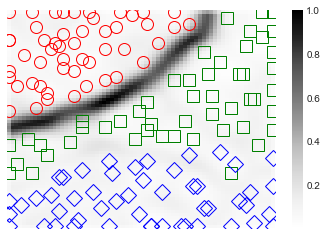

In [21]:
#Answer 6
som_sz = 70
n_features = 4
max_iter = 1000

np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=3, init_sigma=30.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()

plt.pcolor(iris_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])

markers = ['o','s','D']
colors = ['r','g','b']

for i in range(len(iris_x)):
    bmu_pos = iris_som.get_bmu(iris_x[i])
    plt.plot(bmu_pos[0] + 0.5,
             bmu_pos[1] + 0.5,
             markers[iris_y[i]],
             markeredgecolor=colors[iris_y[i]],
             markersize=12,
             markerfacecolor='None')
plt.show()

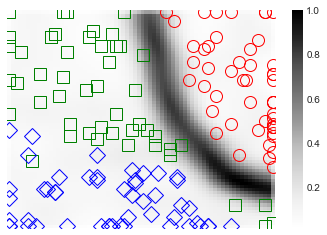

In [22]:
#Answer 6
som_sz = 70
n_features = 4
max_iter = 2000

np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=3, init_sigma=51.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()

plt.pcolor(iris_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])

markers = ['o','s','D']
colors = ['r','g','b']

for i in range(len(iris_x)):
    bmu_pos = iris_som.get_bmu(iris_x[i])
    plt.plot(bmu_pos[0] + 0.5,
             bmu_pos[1] + 0.5,
             markers[iris_y[i]],
             markeredgecolor=colors[iris_y[i]],
             markersize=12,
             markerfacecolor='None')
plt.show()

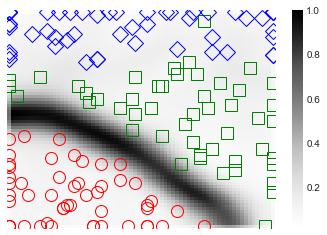

In [23]:
#Answer 6
som_sz = 70
n_features = 4
max_iter = 1000

np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=1, init_sigma=51.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()

plt.pcolor(iris_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])

markers = ['o','s','D']
colors = ['r','g','b']

for i in range(len(iris_x)):
    bmu_pos = iris_som.get_bmu(iris_x[i])
    plt.plot(bmu_pos[0] + 0.5,
             bmu_pos[1] + 0.5,
             markers[iris_y[i]],
             markeredgecolor=colors[iris_y[i]],
             markersize=12,
             markerfacecolor='None')
plt.show()

In [24]:
#Answer 6
som_sz = 70
n_features = 4
max_iter = 1000
np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=10, init_sigma=51.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()

plt.pcolor(iris_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])

markers = ['o','s','D']
colors = ['r','g','b']

for i in range(len(iris_x)):
    bmu_pos = iris_som.get_bmu(iris_x[i])
    plt.plot(bmu_pos[0] + 0.5,
             bmu_pos[1] + 0.5,
             markers[iris_y[i]],
             markeredgecolor=colors[iris_y[i]],
             markersize=12,
             markerfacecolor='None')
plt.show()

C:\Users\mynam\onedrive\documents\classes\NeuralNetworks\project5\som.py:206: RuntimeWarning: overflow encountered in multiply
  def error(self, data):
C:\Users\mynam\onedrive\documents\classes\NeuralNetworks\project5\som.py:206: RuntimeWarning: invalid value encountered in add
  def error(self, data):


KeyboardInterrupt: 

### c. Visualize word embedding vectors

The below parameters should work out-of-the-box for creating a "word cloud" of the IMDb word embedding vectors. Tweak as needed.

In [25]:
word_vectors = np.load('results/imdb_word_vectors.npy')
word_strings = np.load('results/imdb_word_strings.npy')
print(f'Loaded {len(word_vectors)} word embedding vectors and {len(word_strings)} words.')

Loaded 1016 word embedding vectors and 1016 words.


#### Train the SOM on word vectors and look at the U-matrix

- Create a SOM object, fit it to the word vectors, get the U-matrix (`word_u_map`), use the below code to plot it.

Training should take around 1 minutes or less with the following default parameters:

- size of SOM (in either x or y): 100
- max iterations: 100,000
- learning rate: 2
- initial Gaussian neighborhood standard deviation: 40

The U-matrix should have structure to it (not look like salt-and-pepper pixel noise or be completely black/white/gray)

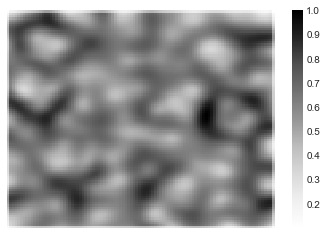

In [41]:
# Make SOM here, train it, etc
som_sz = 100
n_features = 10
max_iter = 1000
np.random.seed(0)

word_som = som.SOM(som_sz, n_features, max_iter, init_lr=2, init_sigma=40.0, verbose=False)
word_som.fit(word_vectors.copy())
word_u_map = word_som.u_matrix()

plt.pcolor(word_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

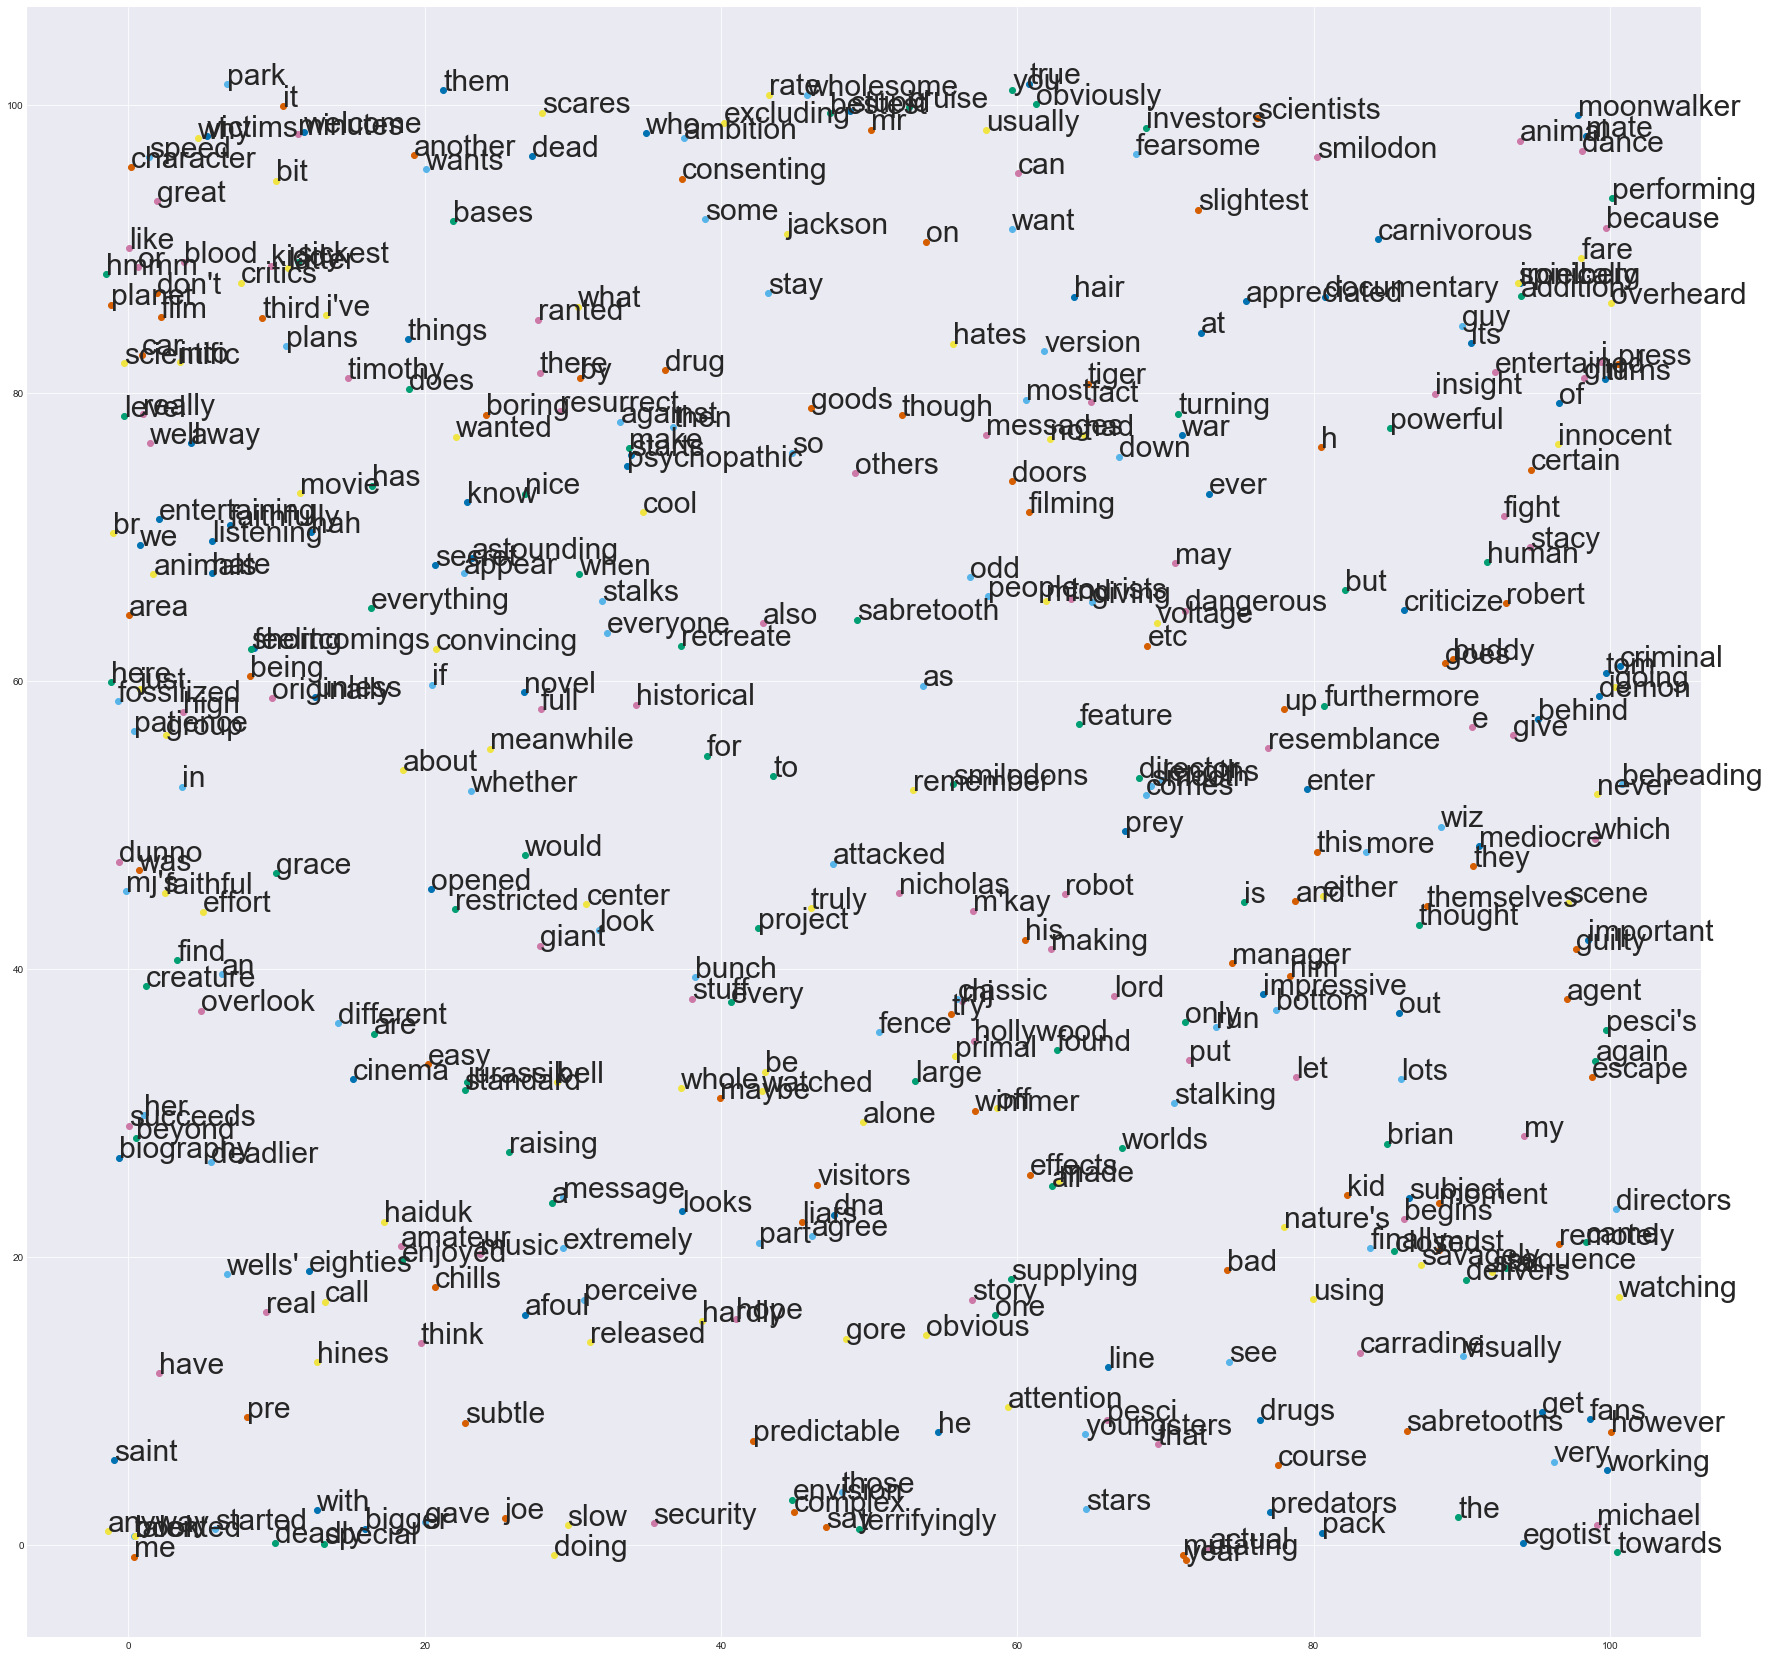

In [43]:
num_words_to_visualize = 400
jitter = 2

fig, ax = plt.subplots(figsize=(30, 30))
for i in range(len(word_vectors[:num_words_to_visualize])):
    bmu_pos = word_som.get_bmu(word_vectors[i])
    # jitter the placement of words so that they are less likely to plot ontop of each other
    x = bmu_pos[0] + 0.5 + jitter*(2*np.random.random()-1)
    y = bmu_pos[1] + 0.5 + jitter*(2*np.random.random()-1)
    ax.scatter(x, y)
    ax.annotate(str(word_strings[i]), (x, y), fontsize=30)
plt.show()

**Question 9:** What are your favorite word clusters? Are there any word groupings that surprised you (but make sense post-hoc)?

**Answer 9:** Our favorite word cluster has to be the one with hollywood, cameo, and directors. This one obviously makes sense because they're all used in movies, and this is the imdb dataset. We can also see clusters that have words that are commonly used together, such as found, out, and who. This would make sense for the IMDB dataset because people are talking about the plots of movies and they might say something about finding out who did something in the movie. 

**Question 10:** How does the number of iterations affect the apparent quality of the word vector mapping? For example, does the visualization make sense when you decrease/increase the iteration count? How stable does it seem? Does it break down at any point?

**Answer 10:** When I put it on 10 iterations, it creates two big clusters that are really far away from each other. This makes sense because there really wasn't much training that could have gone on, so the data is bound to be weird. The u-matrix has a black part in one corner and the rest is mostly white. 

When I do 100 iterations, there are some black lines running through the u-matrix and the word cloud is much more spread out. The clusters don't really make sense, but I do see that "drugs" and "bad" are together, which is a good piece of advice from the word cloud. 

When I do 1000 iterations, there is more structure in the u-matrix, which is expected. The word cloud has more clusters than the one with 100 iterations. I see "demon" and "criminal" together, which makes sense because both things are bad. I also see animate, dance, and moonwalker are together, which  makes sense as well.

## Extensions

### 1. Other SOM initialization schemes

Other initialization schemes initialize the SOM weights to random values in the training set or according to the 1st two principle components of the data. Investigate how these affect the stablity and convergence of the network weights. 

### 2. SOM quantization error

Do an analysis (make plots, explain findings) where you investigate how various SOM parameters affect the quantization error. Parameters you might experiment with are:
- iteration count
- SOM size

**NOTE:** Some parameters may need to adjusted together in some fashion. For example, decreasing the SOM size decreases the grid size. Therefore, the Gaussian neighborhood size $\sigma$ probably needs to be rescaled, as does the learning rate (how much vectors move around in the space duing each update).

### 3. More sophisticated text preprocessing

To preprocess text for Skipgram, we defined words as strings with at least one letter. Research and examine whether more sophisticated approaches (e.g. removing stop words, destemming, lemmatization, etc) to preprocessing text yield better word embedding results (better quality word context predictions, better word similiarity as represented by the SOM).

### 4. Skip-gram word context

We only used the Skip-gram network to extract the word embedding vectors. Load in the IMDb test set and explore how a trained Skip-gram network can predict words surrounding each target work. This may require overriding the `predict` function and looking at the softmax values.

### 5. Continuous Bag of Words (CBOW)

In addition to Skip-gram, Mikolov et al. also proposed the CBOW model. Duplicate your Skipgram code and make the necessary modifications to implement CBOW. Note that this requires similar modifications that we made to the output layer, but to the hidden layer. The main change is that we present multiple context word one-hot vectors "at once": compute `y_net_in` for each context word, then average them across the layer (to get a $1\times H$ vector) before computing `y_net_act`. Then proceed like normal with the rest of the forward pass. Because there's one correct class, use standard cross-entropy loss. The backprop process is the same until you get to computing the hidden layer (`y`) `d_wts`. Because we averaged $C$ inputs when computing `y_net_in`, we have the divide `d_wts` by $C$.

- How do the word vectors compare to Skipgram?
- Analyze the target word predictions.

### 6. Removing one-hot vectors from Skip-gram and add mini-batch support

- In our Skip-gram implementation, we one-hot coded all target words upfront. This is wasteful with respect to memory consumption because one-hot input vectors simply select the weights of $i^{th}$ hidden layer unit. Override the `Dense` net_in computation method and modify it to handle int indices.

- Another improvement would be to add mini-batch support to training. This may be easier to implement if you bypass all usage of one-hot vectors.

### 7. Quality of SOM word clusters

Experiment with how SOM learning parameters and Skip-gram training time (and other parameters like # embedding dimensions) affect the quality of similar word cluster.

### 8. Other text datasets

Obtain, load, and preprocess other text datasets. Train Skip-gram, visualize the word vectors using SOM, and interpret what you find.